In [1]:
import os
import time
import glob
import numba
import random
import itertools
import torch
import torch.nn as nn
import matplotlib.pyplot as plt

import numpy as np
import pandas as pd

from tqdm import tqdm
from sklearn.model_selection import train_test_split
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import Dataset, DataLoader

In [2]:
torch.__version__

'1.7.0+cu110'

In [3]:
DATA_PATH = '../data/'
RANDOM_SEED = 42

In [4]:
def seed_everything(seed=0):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True

In [5]:
seed_everything(RANDOM_SEED)

In [6]:
# @numba.jit
def stress_pos(x):
    try:
        res = np.zeros(len(x)-1)
        stress_idx = x.find('+')
        res[stress_idx] = 1
        return res
    except IndexError:
        return np.NaN

In [7]:
data = []

for file in tqdm(glob.glob(DATA_PATH + "dictionary/" + "*.txt")):
    with open(file, encoding='cp1251') as fil:
        lines = fil.readlines()
        for line in lines:
            try:
                word1, word2 = line.strip().split(" ")
                word1, word2 = word1.strip().replace('i', 'і'), word2.strip().replace('i', 'і')
                data.append((word1, word2))
            except ValueError:
                continue

100%|██████████| 34/34 [00:04<00:00,  6.85it/s]


In [8]:
data = pd.DataFrame(data)
data.columns = ['word', 'word_with_stress']

In [9]:
exclude_list = [
    '\t', '$', '%', '-', '\\', '`', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 
    'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 
    'v', 'w', 'x', 'y', 'z', '~', '\xa0', '\xad', '·', 'ђ', 'ј', 'љ', 'њ', 'ћ', 
    'ў', 'џ', '–', '‘', '’', '“', '”', '•', '№',
    'ъ', 'ы', 'э'
]

for item in tqdm(exclude_list):
    data = data.loc[~data.word.str.contains(item, regex=False)]

100%|██████████| 53/53 [01:04<00:00,  1.22s/it]


In [10]:
%%time

data['word_list'] = data.word.map(list)

CPU times: user 12 s, sys: 1.29 s, total: 13.3 s
Wall time: 13.2 s


In [11]:
%%time

data['word_stress_pos'] = data.word_with_stress.map(stress_pos)

CPU times: user 3.98 s, sys: 115 ms, total: 4.1 s
Wall time: 4.1 s


In [12]:
data = data.loc[data.word_stress_pos.notna()]

In [13]:
data.sample(5)

,word,word_with_stress,word_list,word_stress_pos
1024316,пивничого,пивн+ичого,"[п, и, в, н, и, ч, о, г, о]","[0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0]"
1011665,перехитрило,перехитр+ило,"[п, е, р, е, х, и, т, р, и, л, о]","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, ..."
224015,відгризатиметься,відгриз+атиметься,"[в, і, д, г, р, и, з, а, т, и, м, е, т, ь, с, я]","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, ..."
2127636,розбірною,розб+ірною,"[р, о, з, б, і, р, н, о, ю]","[0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0]"
2792530,ексудат,ексуд+ат,"[е, к, с, у, д, а, т]","[0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0]"


In [14]:
max_sequence_len = np.max(data.word.str.len())
max_sequence_len

28

In [15]:
def flatten(array):
    for item in array:
        if isinstance(item, list):
            yield from flatten(item)
        else:
            yield item


class SequenceTokenizer:
    
    def __init__(self):
        self.word2index = {}
        self.index2word = {}
        self.oov_token ='<UNK>'
        self.oov_token_index = 0
        
    def fit(self, sequence):
        self.index2word = dict(enumerate([self.oov_token] + sorted(set(flatten(sequence))), 1))
        self.word2index = {v:k for k,v in self.index2word.items()}
        self.oov_token_index = self.word2index.get(self.oov_token)
        return self
    
    def transform(self, X):
        res = []
        for line in X:
            res.append([self.word2index.get(item, self.oov_token_index) for item in line])
        return res

In [16]:
tokenizer = SequenceTokenizer()
tokenizer.fit(data.word_list);

In [17]:
tokenizer.word2index

{'<UNK>': 1,
 'а': 2,
 'б': 3,
 'в': 4,
 'г': 5,
 'д': 6,
 'е': 7,
 'ж': 8,
 'з': 9,
 'и': 10,
 'й': 11,
 'к': 12,
 'л': 13,
 'м': 14,
 'н': 15,
 'о': 16,
 'п': 17,
 'р': 18,
 'с': 19,
 'т': 20,
 'у': 21,
 'ф': 22,
 'х': 23,
 'ц': 24,
 'ч': 25,
 'ш': 26,
 'щ': 27,
 'ь': 28,
 'ю': 29,
 'я': 30,
 'є': 31,
 'і': 32,
 'ї': 33,
 'ґ': 34}

In [18]:
X = tokenizer.transform(data.word_list)

In [58]:
def pad_sequence(lst, max_seq=max_sequence_len):
    if isinstance(lst[0], list):
        return np.array([i + [0]*(max_seq-len(i)) for i in lst])
    else:
        lst + [0]*(max_seq-len(lst))

In [60]:
# %%time

# input_seq = zip(*itertools.zip_longest(*X, fillvalue=0))
# input_seq = list(map(list, input_seq))
# input_seq = np.array(input_seq)

In [61]:
%%time

input_seq = pad_sequence(X)

CPU times: user 12.1 s, sys: 620 ms, total: 12.7 s
Wall time: 12.7 s


In [20]:
print(input_seq.shape)
input_seq

(2757242, 28)


array([[21, 32, 13, ...,  0,  0,  0],
       [21, 32, 13, ...,  0,  0,  0],
       [21, 32, 13, ...,  0,  0,  0],
       ...,
       [ 7, 22, 32, ...,  0,  0,  0],
       [ 7, 13, 13, ...,  0,  0,  0],
       [ 7, 14,  3, ...,  0,  0,  0]])

In [21]:
y = data.word_stress_pos.values

In [22]:
output_seq = zip(*itertools.zip_longest(*y, fillvalue=0))
output_seq = list(map(list, output_seq))
output_seq = np.array(output_seq).astype(int)

In [23]:
print(output_seq.shape)
output_seq

(2757242, 28)


array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 1, ..., 0, 0, 0],
       [0, 1, 0, ..., 0, 0, 0],
       [0, 1, 0, ..., 0, 0, 0]])

In [24]:
(input_seq_train, input_seq_val, 
 output_seq_train, output_seq_val) = train_test_split(input_seq, 
                                                      output_seq, 
                                                      test_size=0.5, 
                                                      random_state=RANDOM_SEED)

In [25]:
input_seq_train = torch.tensor(input_seq_train, dtype=torch.long).cuda()
input_seq_val = torch.tensor(input_seq_val, dtype=torch.long).cuda()
output_seq_train = torch.tensor(output_seq_train, dtype=torch.float).cuda()
output_seq_val = torch.tensor(output_seq_val, dtype=torch.float).cuda()

In [26]:
class MyDataset(Dataset):
    def __init__(self, dataset):
        self.dataset = dataset
        
    def __getitem__(self, index):
        data,target = self.dataset[index]
        return data, target, index
    
    def __len__(self):
        return len(self.dataset)

In [27]:
class LSTM_model(nn.Module):

    def __init__(self, embedding_dim, hidden_dim, vocab_size, target_size):
        super(LSTM_model, self).__init__()
        self.hidden_dim = hidden_dim

        self.embeddings = nn.Embedding(vocab_size, embedding_dim)

        self.lstm = nn.LSTM(input_size=self.embeddings.embedding_dim,
                            hidden_size=hidden_dim,
                            num_layers=2,
                            batch_first=True,
                            bidirectional=True)
        self.linear = nn.Linear(self.hidden_dim * 4 , 64)
        self.batch_norm = nn.BatchNorm1d(self.hidden_dim * 4, affine=False)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.2)
        self.out = nn.Linear(32, target_size)

    def forward(self, x):
        h_embeddings = self.embeddings(x)
        
        h_lstm, _ = self.lstm(h_embeddings)
        avg_pool = torch.mean(h_lstm, 1)
        max_pool, _ = torch.max(h_lstm, 1)
        x = torch.cat((avg_pool, max_pool), 1)
        x = self.batch_norm(x)
        x = self.linear(x)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.out(x)
        y = nn.functional.softmax(x, dim=1)
        return y

In [28]:
model = LSTM_model(embedding_dim=64, 
                   hidden_dim=32, 
                   vocab_size=len(tokenizer.word2index) + 1, 
                   target_size=max_sequence_len)
model.cuda()

LSTM_model(
  (embeddings): Embedding(35, 64)
  (lstm): LSTM(64, 32, num_layers=2, batch_first=True, bidirectional=True)
  (linear): Linear(in_features=128, out_features=64, bias=True)
  (batch_norm): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
  (relu): ReLU()
  (dropout): Dropout(p=0.2, inplace=False)
  (out): Linear(in_features=64, out_features=28, bias=True)
)

In [29]:
loss_function = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=1e-3)

In [31]:
BATCH_SIZE = 256

train = MyDataset(torch.utils.data.TensorDataset(input_seq_train, output_seq_train))
valid = MyDataset(torch.utils.data.TensorDataset(input_seq_val, output_seq_val))

train_loader = torch.utils.data.DataLoader(train, batch_size=BATCH_SIZE, shuffle=True)
valid_loader = torch.utils.data.DataLoader(valid, batch_size=BATCH_SIZE, shuffle=False)

In [32]:
# with torch.no_grad():
#     (x_sample, y_sample, index) = train[:2]
#     preds = model(x_sample.reshape(1, -1))
#     print(preds.shape)

### K-Fold training

In [33]:
from sklearn.model_selection import KFold

In [34]:
n_folds = 5

In [35]:
kf = KFold(n_splits=n_folds, shuffle=True, random_state=RANDOM_SEED)
# kf.get_n_splits(X=input_seq, y=output_seq)

In [36]:
for train_index, test_index in kf.split(X=input_seq, y=output_seq):
    print(train_index.shape, test_index.shape)

(2205793,) (551449,)
(2205793,) (551449,)
(2205794,) (551448,)
(2205794,) (551448,)
(2205794,) (551448,)


In [37]:
input_seq

array([[21, 32, 13, ...,  0,  0,  0],
       [21, 32, 13, ...,  0,  0,  0],
       [21, 32, 13, ...,  0,  0,  0],
       ...,
       [ 7, 22, 32, ...,  0,  0,  0],
       [ 7, 13, 13, ...,  0,  0,  0],
       [ 7, 14,  3, ...,  0,  0,  0]])

### Training loop

In [38]:
n_epochs = 1
history = {'train': {}, 'val': {}}
teacher_forcing_ratio = 0.5

for epoch in range(1, n_epochs + 1):
    start_time = time.time()
    
    model.train()

    avg_loss, total_loss, avg_acc, total_acc = 0., 0., 0., 0.
    for i, (x_batch, y_batch, index) in enumerate(train_loader):
        y_pred = model(x_batch)
        loss = loss_function(y_pred, y_batch)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        equal = torch.eq(torch.argmax(y_pred, axis=1), torch.argmax(y_batch, axis=1))
        batch_acc = int(equal.sum(-1)) / y_batch.shape[0]
        batch_loss = loss.item()
        
        total_acc += batch_acc
        total_loss += batch_loss
        print(f"\rEpoch [{epoch}/{n_epochs}] "
              f" progress = {round(i/len(train_loader)*100)}% "
              f"\t loss={total_loss / (i + 1):.4f} "
              f"\t acc={total_acc / (i + 1) * 100:.2f}% ", end='')
    avg_loss = total_loss / len(train_loader)
    avg_acc = total_acc / len(train_loader)
    history['train']['loss'] = history.get('train', {}).get('loss', []) + [avg_loss]
    history['train']['accuracy'] = history.get('train', {}).get('accuracy', []) + [avg_acc]
        
    model.eval()

    
    avg_val_loss, total_val_loss, avg_val_acc, total_val_acc = 0., 0., 0., 0.
    for i, (x_batch, y_batch, index) in enumerate(valid_loader):
        y_pred = model(x_batch).detach()
        val_loss = loss_function(y_pred, y_batch)
        
        equal = torch.eq(torch.argmax(y_pred, axis=1), torch.argmax(y_batch, axis=1))
        batch_val_acc = int(equal.sum(-1)) / y_batch.shape[0]
        batch_val_loss = val_loss.item()
        
        total_val_acc += batch_val_acc
        total_val_loss += batch_val_loss
    avg_val_loss = total_val_loss / len(valid_loader)
    avg_val_acc = total_val_acc / len(valid_loader)
    history['val']['loss'] = history.get('val', {}).get('loss', []) + [avg_val_loss]
    history['val']['accuracy'] = history.get('val', {}).get('accuracy', []) + [avg_val_acc]
    
    elapsed_time = time.time() - start_time 
    print(f"\nEpoch [{epoch}/{n_epochs}]  results:"
          f"\t\t loss={avg_loss:.4f}"
          f"\t acc={avg_acc * 100:.2f}%"
          f"\t val_loss={avg_val_loss:.4f}"
          f"\t val_acc={avg_val_acc * 100:.2f}%"
          f"\t time={elapsed_time:.2f}s")
    print("-"*78)

Epoch [1/50]  progress = 100% 	 loss=0.6935 	 acc=60.50% 
Epoch [1/50]  results:		 loss=0.6935	 acc=60.50%	 val_loss=0.6902	 val_acc=69.91%	 time=197.03s
------------------------------------------------------------------------------
Epoch [2/50]  progress = 100% 	 loss=0.6895 	 acc=72.00% 
Epoch [2/50]  results:		 loss=0.6895	 acc=72.00%	 val_loss=0.6889	 val_acc=73.53%	 time=193.91s
------------------------------------------------------------------------------
Epoch [3/50]  progress = 100% 	 loss=0.6887 	 acc=74.30% 
Epoch [3/50]  results:		 loss=0.6887	 acc=74.30%	 val_loss=0.6880	 val_acc=76.46%	 time=197.00s
------------------------------------------------------------------------------
Epoch [4/50]  progress = 100% 	 loss=0.6880 	 acc=76.45% 
Epoch [4/50]  results:		 loss=0.6880	 acc=76.45%	 val_loss=0.6877	 val_acc=77.05%	 time=193.29s
------------------------------------------------------------------------------
Epoch [5/50]  progress = 100% 	 loss=0.6877 	 acc=77.16% 
Epoch [5/5

Epoch [36/50]  progress = 100% 	 loss=0.6865 	 acc=80.59% 
Epoch [36/50]  results:		 loss=0.6865	 acc=80.59%	 val_loss=0.6865	 val_acc=80.71%	 time=194.77s
------------------------------------------------------------------------------
Epoch [37/50]  progress = 100% 	 loss=0.6865 	 acc=80.58% 
Epoch [37/50]  results:		 loss=0.6865	 acc=80.58%	 val_loss=0.6863	 val_acc=81.24%	 time=197.09s
------------------------------------------------------------------------------
Epoch [38/50]  progress = 100% 	 loss=0.6865 	 acc=80.63% 
Epoch [38/50]  results:		 loss=0.6865	 acc=80.63%	 val_loss=0.6866	 val_acc=80.22%	 time=194.56s
------------------------------------------------------------------------------
Epoch [40/50]  progress = 100% 	 loss=0.6865 	 acc=80.53% 
Epoch [40/50]  results:		 loss=0.6865	 acc=80.53%	 val_loss=0.6864	 val_acc=80.92%	 time=192.52s
------------------------------------------------------------------------------
Epoch [41/50]  progress = 100% 	 loss=0.6864 	 acc=80.94% 
E

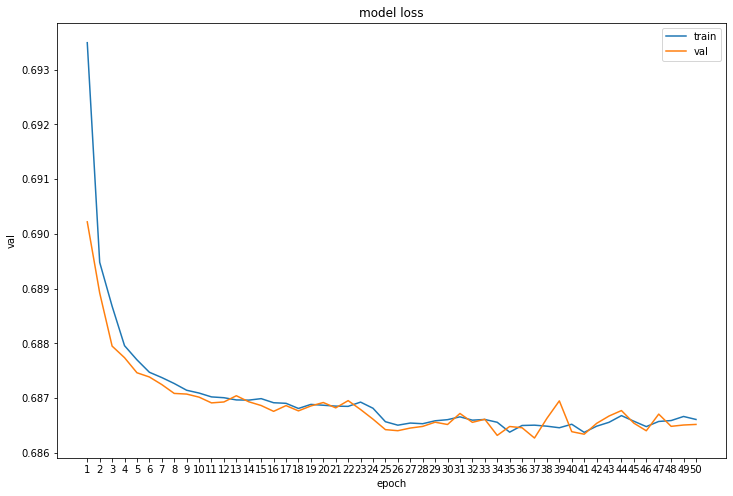

In [42]:
plt.figure(figsize=(12, 8))

plt.plot(history['train']['loss'])
plt.plot(history['val']['loss'])
plt.title('model loss')
plt.ylabel('val')
plt.xlabel('epoch')
plt.xticks(np.arange(len(history['train']['loss'])), np.arange(1, len(history['train']['loss']) + 1))
plt.legend(['train', 'val'], loc='upper right')

plt.show()

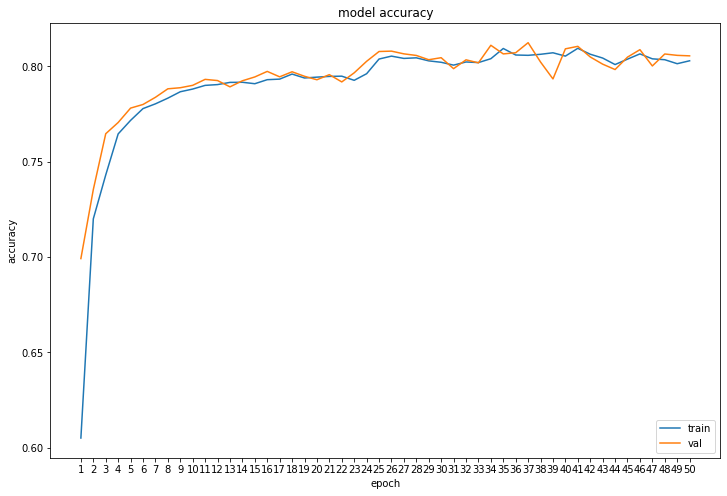

In [43]:
plt.figure(figsize=(12, 8))

plt.plot(history['train']['accuracy'])
plt.plot(history['val']['accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.xticks(np.arange(len(history['train']['accuracy'])), np.arange(1, len(history['train']['accuracy']) + 1))
plt.legend(['train', 'val'], loc='lower right')

plt.show()

### Predict

In [113]:
def predict(words, mode='stress'):
    tokens = pad_sequence(tokenizer.transform(words))
    sequences = torch.tensor(tokens, dtype=torch.long).cuda()
    preds = model(sequences)
    indeces = torch.argmax(preds, axis=1)
    if mode == 'stress':
        return [word[:index+1] + chr(769) + word[index+1:] for word, index in zip(words, indeces)]
    elif mode == 'asterisk':
        return [word[:index+1] + "*" + word[index+1:] for word, index in zip(words, indeces)]
    else:
        raise ValueError(f"Wrong `mode`={mode}")

In [114]:
words = ["словотворення", "архаїчний"]

In [115]:
predict(words)

['словотво́рення', 'арха́їчний']